# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import joblib
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from transformers import BertTokenizer, TFBertModel
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
from tqdm import tqdm
import nltk  # For text processing
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to C:\Users\JIYA
[nltk_data]     SONI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\JIYA
[nltk_data]     SONI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import torch
print(torch.__version__)

2.9.0+cpu


# Import Dataset

In [3]:
file_path = "tweet_data.csv"  # Ensure the file is in the working directory
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12-05-2013 1.48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.590000e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10-01-2012 13.51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.590000e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.590000e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,06-11-2009 22.39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.590000e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.590000e+17,NaN,NaN


# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _golden                20050 non-null  bool   
 2   _unit_state            20050 non-null  object 
 3   _trusted_judgments     20050 non-null  int64  
 4   _last_judgment_at      20000 non-null  object 
 5   gender                 19953 non-null  object 
 6   gender:confidence      20024 non-null  float64
 7   profile_yn             20050 non-null  object 
 8   profile_yn:confidence  20050 non-null  float64
 9   created                20050 non-null  object 
 10  description            16306 non-null  object 
 11  fav_number             20050 non-null  int64  
 12  link_color             20050 non-null  object 
 13  name                   20050 non-null  object 
 14  profile_yn_gold        50 non-null     object 
 15  pr

In [5]:
df.describe()

,_unit_id,_trusted_judgments,gender:confidence,profile_yn:confidence,fav_number,retweet_count,tweet_count,tweet_id
count,2.005000e+04,20050.000000,20024.000000,20050.000000,20050.000000,20050.000000,2.005000e+04,2.005000e+04
mean,8.157294e+08,3.615711,0.882756,0.993221,4382.201646,0.079401,3.892469e+04,6.590000e+17
std,6.000801e+03,12.331890,0.191403,0.047168,12518.575919,2.649751,1.168371e+05,0.000000e+00
min,8.157192e+08,3.000000,0.000000,0.627200,0.000000,0.000000,1.000000e+00,6.590000e+17
25%,8.157243e+08,3.000000,0.677800,1.000000,11.000000,0.000000,2.398000e+03,6.590000e+17
50%,8.157294e+08,3.000000,1.000000,1.000000,456.000000,0.000000,1.144150e+04,6.590000e+17
75%,8.157345e+08,3.000000,1.000000,1.000000,3315.500000,0.000000,4.002750e+04,6.590000e+17
max,8.157580e+08,274.000000,1.000000,1.000000,341621.000000,330.000000,2.680199e+06,6.590000e+17


C:\Users\JIYA SONI\AppData\Local\Temp\ipykernel_20920\2699724752.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.index, y=missing_values.values, palette="coolwarm")


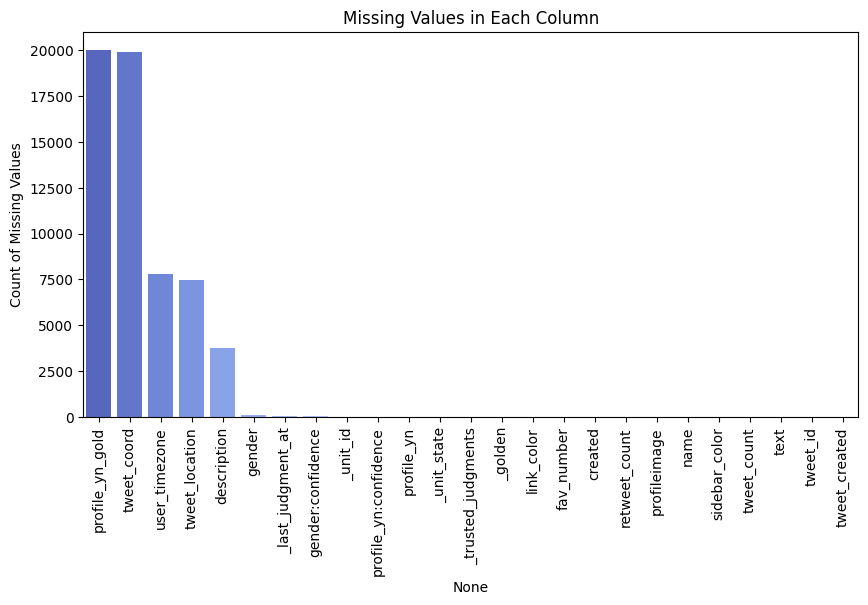

profile_yn_gold          20000
tweet_coord              19891
user_timezone             7798
tweet_location            7485
description               3744
gender                      97
_last_judgment_at           50
gender:confidence           26
_unit_id                     0
profile_yn:confidence        0
profile_yn                   0
_unit_state                  0
_trusted_judgments           0
_golden                      0
link_color                   0
fav_number                   0
created                      0
retweet_count                0
profileimage                 0
name                         0
sidebar_color                0
tweet_count                  0
text                         0
tweet_id                     0
tweet_created                0
dtype: int64


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check for missing values
missing_values = df.isnull().sum().sort_values(ascending=False)

# Plot missing values
plt.figure(figsize=(10, 5))
sns.barplot(x=missing_values.index, y=missing_values.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.ylabel("Count of Missing Values")
plt.title("Missing Values in Each Column")
plt.show()

# Display missing values count
print(missing_values)

In [7]:
df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

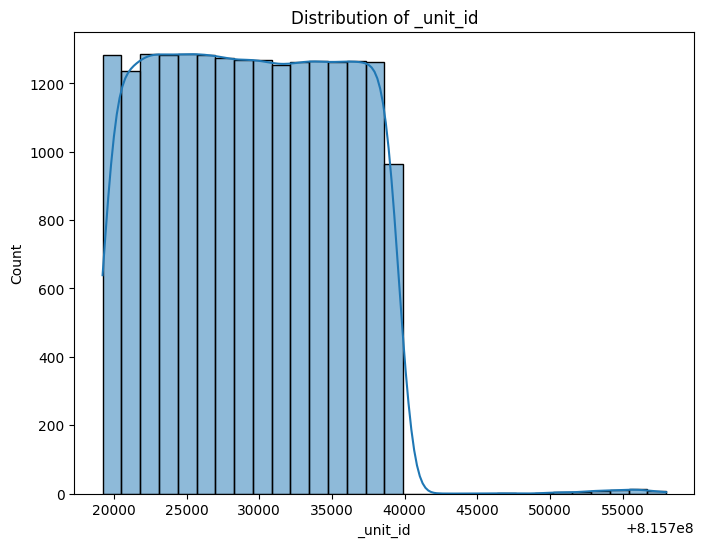

C:\Users\JIYA SONI\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20050.
  res = hypotest_fun_out(*samples, **kwds)


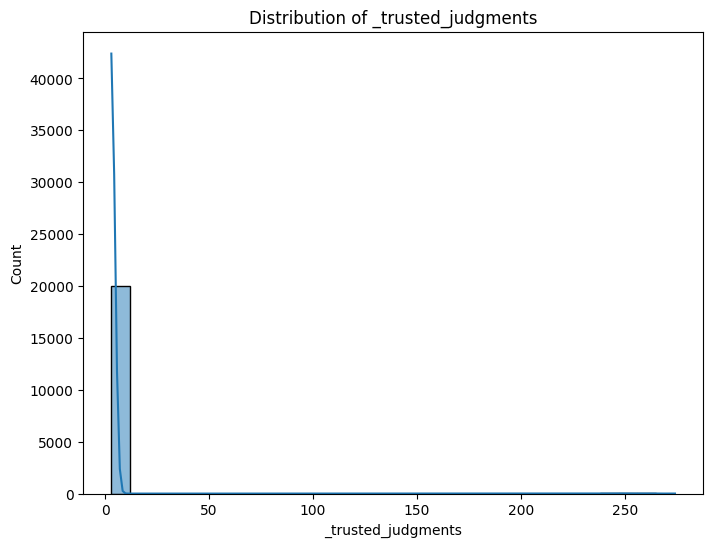

C:\Users\JIYA SONI\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20050.
  res = hypotest_fun_out(*samples, **kwds)


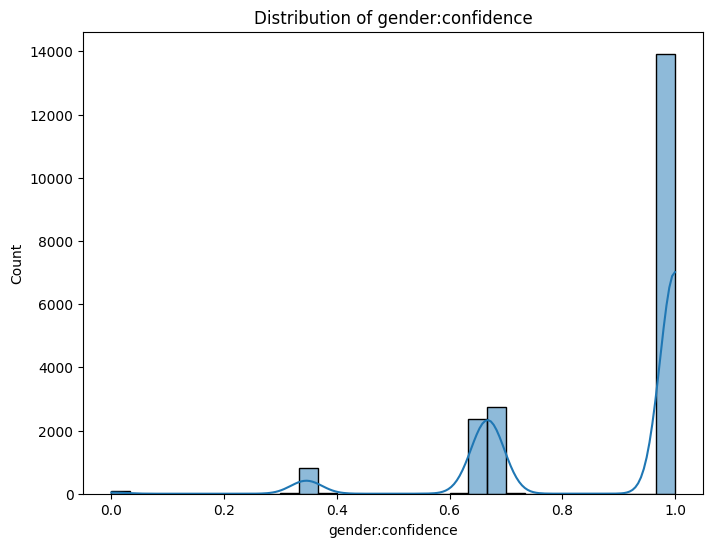

C:\Users\JIYA SONI\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20024.
  res = hypotest_fun_out(*samples, **kwds)


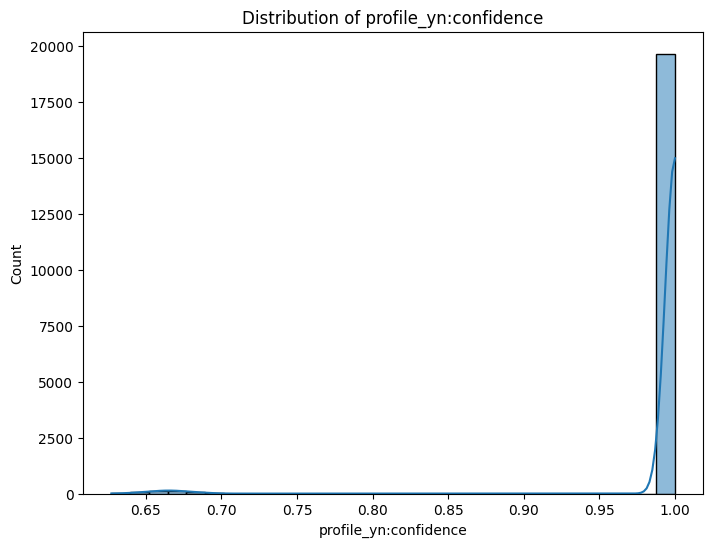

C:\Users\JIYA SONI\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20050.
  res = hypotest_fun_out(*samples, **kwds)


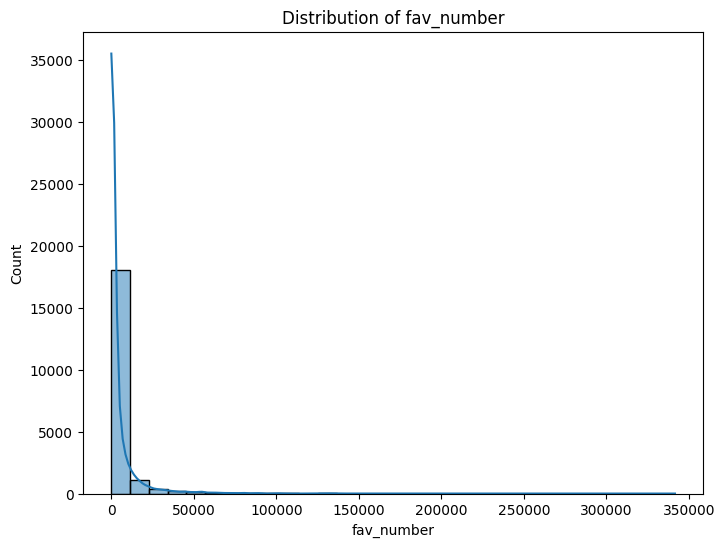

C:\Users\JIYA SONI\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20050.
  res = hypotest_fun_out(*samples, **kwds)


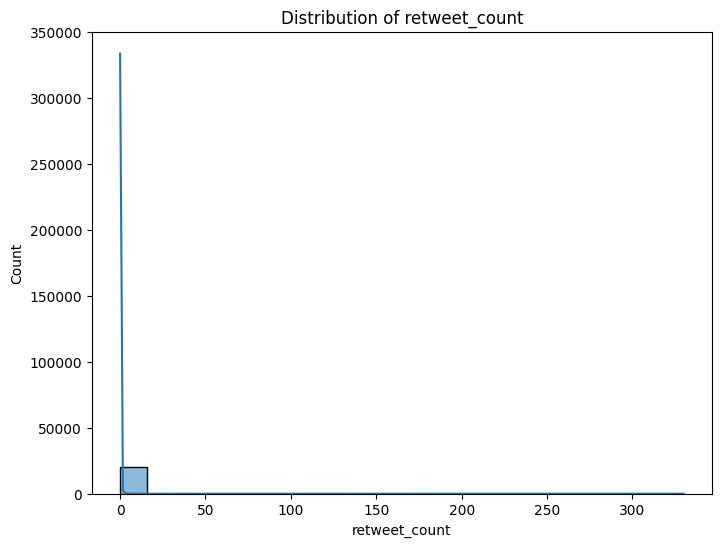

C:\Users\JIYA SONI\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20050.
  res = hypotest_fun_out(*samples, **kwds)


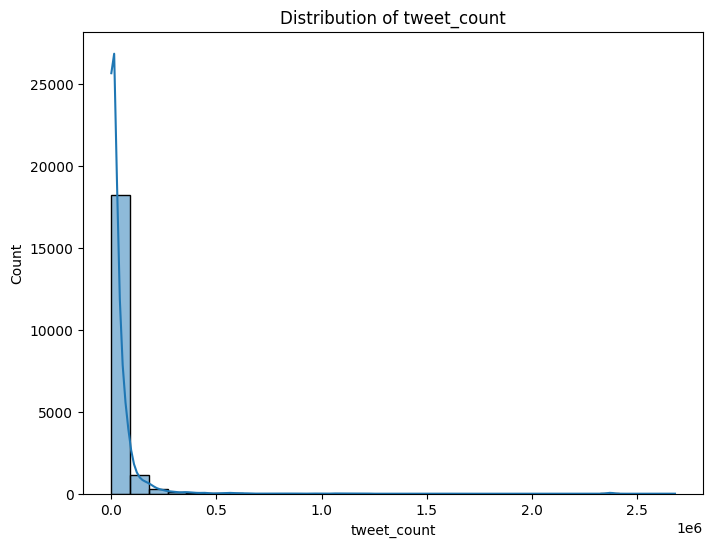

Skipping tweet_id: Only one unique value present.
Normality Test Results (p-value):
{'_unit_id': np.float64(4.279058481213974e-59), '_trusted_judgments': np.float64(3.3125606493107536e-135), 'gender:confidence': np.float64(4.769007889221569e-108), 'profile_yn:confidence': np.float64(3.8708877801019164e-132), 'fav_number': np.float64(2.9423613459827514e-123), 'retweet_count': np.float64(1.1303771403553726e-135), 'tweet_count': np.float64(5.016253516223592e-127)}


C:\Users\JIYA SONI\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20050.
  res = hypotest_fun_out(*samples, **kwds)


In [8]:
# This code checks the normality of all numerical columns in the DataFrame by plotting their distributions and performing the Shapiro-Wilk test.
from scipy.stats import shapiro

# Function to check normality of numerical columns
def check_normality(df):
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    normality_results = {}

    for col in numerical_cols:
        # Drop NaN values
        data = df[col].dropna()
        
        # Check unique values
        unique_values = data.unique()
        if len(unique_values) < 2:
            print(f"Skipping {col}: Only one unique value present.")
            continue

        # Set a safe number of bins
        num_bins = max(1, min(30, len(unique_values) - 1))

        # Plot histogram
        plt.figure(figsize=(8, 6))
        sns.histplot(data, kde=True, bins=num_bins)
        plt.title(f"Distribution of {col}")
        plt.show()

        # Perform Shapiro-Wilk test for normality (if enough data points)
        if len(data) >= 3:
            stat, p_value = shapiro(data)
            normality_results[col] = p_value  # If p_value > 0.05, data is normal
        else:
            print(f"Skipping Shapiro test for {col}: Not enough data points.")

    return normality_results

# Check normality of numerical columns
normality_results = check_normality(df)

# Print out the results of the normality test
print("Normality Test Results (p-value):")
print(normality_results)

In [9]:
# Function to handle missing values based on normality, ensuring columns exist in the normality results
def handle_missing_values_based_on_distribution(df, normality_results):
    for column in df.columns:
        if df[column].dtype == 'object':  # Categorical column
            # Impute with the mode (most frequent value)
            df[column] = df[column].fillna(df[column].mode()[0])
        elif column in normality_results:  # Numerical column and exists in normality_results
            # Check if column is normally distributed using normality test results
            if normality_results[column] > 0.05:  # Normally distributed (use mean)
                df[column] = df[column].fillna(df[column].mean())
            else:  # Not normally distributed (use median)
                df[column] = df[column].fillna(df[column].median())
    return df

# Apply the function to handle missing values
df = handle_missing_values_based_on_distribution(df, normality_results)

# Check missing values after imputation
print(df.isnull().sum())

# Preview the DataFrame after handling missing values
print(df.head())

_unit_id                 0
_golden                  0
_unit_state              0
_trusted_judgments       0
_last_judgment_at        0
gender                   0
gender:confidence        0
profile_yn               0
profile_yn:confidence    0
created                  0
description              0
fav_number               0
link_color               0
name                     0
profile_yn_gold          0
profileimage             0
retweet_count            0
sidebar_color            0
text                     0
tweet_coord              0
tweet_count              0
tweet_created            0
tweet_id                 0
tweet_location           0
user_timezone            0
dtype: int64
    _unit_id  _golden _unit_state  _trusted_judgments _last_judgment_at  \
0  815719226    False   finalized                   3    10/26/15 23:24   
1  815719227    False   finalized                   3    10/26/15 23:30   
2  815719228    False   finalized                   3    10/26/15 23:33   
3  815719229

# Data Cleaning

C:\Users\JIYA SONI\AppData\Local\Temp\ipykernel_20920\2699724752.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.index, y=missing_values.values, palette="coolwarm")


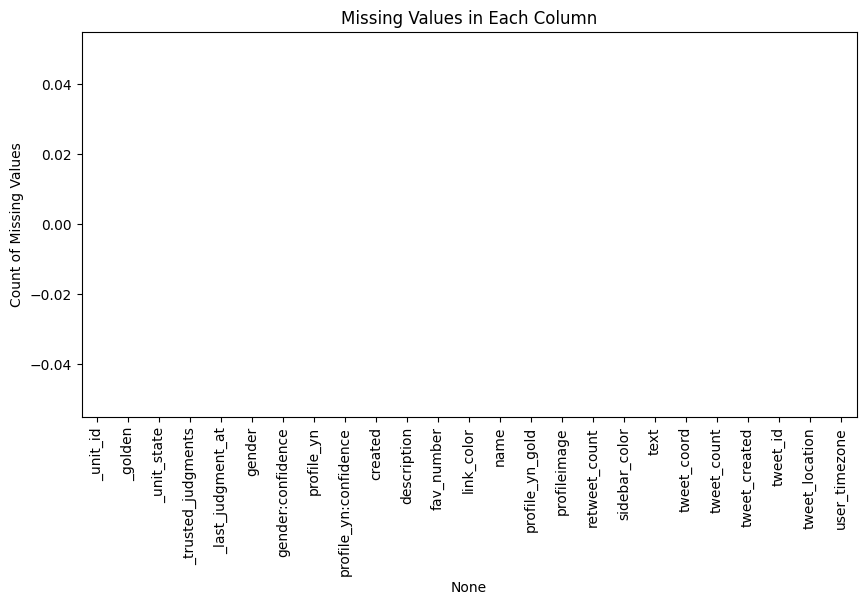

_unit_id                 0
_golden                  0
_unit_state              0
_trusted_judgments       0
_last_judgment_at        0
gender                   0
gender:confidence        0
profile_yn               0
profile_yn:confidence    0
created                  0
description              0
fav_number               0
link_color               0
name                     0
profile_yn_gold          0
profileimage             0
retweet_count            0
sidebar_color            0
text                     0
tweet_coord              0
tweet_count              0
tweet_created            0
tweet_id                 0
tweet_location           0
user_timezone            0
dtype: int64


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check for missing values
missing_values = df.isnull().sum().sort_values(ascending=False)

# Plot missing values
plt.figure(figsize=(10, 5))
sns.barplot(x=missing_values.index, y=missing_values.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.ylabel("Count of Missing Values")
plt.title("Missing Values in Each Column")
plt.show()

# Display missing values count
print(missing_values)

In [11]:
# Remove unnessary Feature
# Define features to drop (less useful or metadata)
drop_features = ['_unit_id', '_last_judgment_at', 'name', 'link_color', 
                 '_golden', '_unit_state', '_trusted_judgments', 
                 'profile_yn_gold']  # additional likely non-predictive columns

# Drop them safely if they exist
df_cleaned = df.drop(columns=[col for col in drop_features if col in df.columns], errors='ignore')

# Show remaining features
print("✅ Remaining columns after cleaning:")
print(df_cleaned.columns.tolist())

# Optional: show summary of remaining dataset
print("\n🧾 Cleaned Dataset Info:")
print(df_cleaned.info())


✅ Remaining columns after cleaning:
['gender', 'gender:confidence', 'profile_yn', 'profile_yn:confidence', 'created', 'description', 'fav_number', 'profileimage', 'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count', 'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone']

🧾 Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 20050 non-null  object 
 1   gender:confidence      20050 non-null  float64
 2   profile_yn             20050 non-null  object 
 3   profile_yn:confidence  20050 non-null  float64
 4   created                20050 non-null  object 
 5   description            20050 non-null  object 
 6   fav_number             20050 non-null  int64  
 7   profileimage           20050 non-null  object 
 8   retweet_count          20050 non-null  int

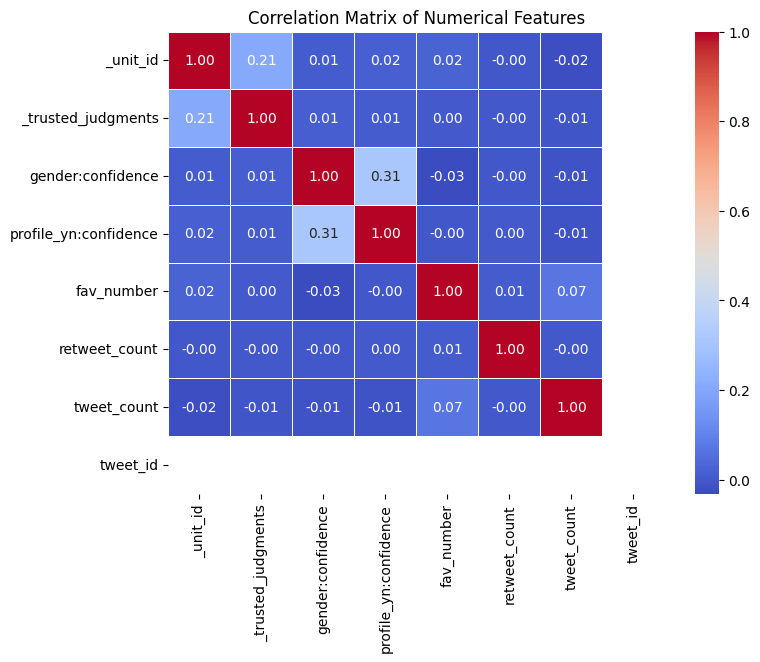

In [12]:
# Compute correlation matrix for numerical columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [13]:
print(df['text'].isna().sum())  # Check missing values
print(df['text'].apply(lambda x: len(str(x).strip())).describe())  # Check text lengths

0
count    20050.000000
mean        97.659152
std         33.936472
min          6.000000
25%         68.000000
50%        102.000000
75%        130.000000
max        425.000000
Name: text, dtype: float64


In [14]:
df = df.drop_duplicates(subset=['text'])  # Remove duplicate tweets
df = df[df['text'].str.len() > 5]  # Remove very short texts


In [15]:
# This code cleans the tweet text by removing URLs, punctuation, numbers, and stopwords.
# It then tokenizes the text, converts it to lowercase, and creates a new 'clean_text' column.

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r"http\S+|www\S+", "", str(text))  # remove URLs
    text = re.sub(r"[^a-zA-Z]", " ", text)  # keep only letters
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text)
df[['text', 'clean_text']].head()


[nltk_data] Downloading package stopwords to C:\Users\JIYA
[nltk_data]     SONI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\JIYA
[nltk_data]     SONI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,clean_text
0,Robbie E Responds To Critics After Win Against...,robbie e responds critics win eddie edwards wo...
1,ÛÏIt felt like they were my friends and I was...,felt like friends living story retired ian
2,i absolutely adore when louis starts the songs...,absolutely adore louis starts songs hits hard ...
3,Hi @JordanSpieth - Looking at the url - do you...,hi jordanspieth looking url use ifttt typicall...
4,Watching Neighbours on Sky+ catching up with t...,watching neighbours sky catching neighbs xxx xxx


In [16]:
# This code performs sentiment analysis using VADER to classify text as positive, neutral, or negative.
# It then maps each sentiment to a numeric label and adds both results to the DataFrame.

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

df['sentiment'] = df['clean_text'].apply(get_sentiment)
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df['label'] = df['sentiment'].map(label_map)

df[['clean_text', 'sentiment']].head()

[nltk_data] Downloading package vader_lexicon to C:\Users\JIYA
[nltk_data]     SONI\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,clean_text,sentiment
0,robbie e responds critics win eddie edwards wo...,positive
1,felt like friends living story retired ian,positive
2,absolutely adore louis starts songs hits hard ...,positive
3,hi jordanspieth looking url use ifttt typicall...,positive
4,watching neighbours sky catching neighbs xxx xxx,neutral


In [17]:
# Count each sentiment category
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

sentiment
positive    8689
neutral     5457
negative    4265
Name: count, dtype: int64


In [18]:
# 🧩 Step 1: Create TF-IDF Features

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming df has 'clean_text' and 'label' columns
X = df['clean_text']
y = df['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit-transform train data and transform test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF features created successfully!")
print("Training shape:", X_train_tfidf.shape)
print("Testing shape:", X_test_tfidf.shape)

# Save the vectorizer correctly
joblib.dump(vectorizer, "tfidf_vectorizer.pkl") 
print("TF-IDF vectorizer saved.")

TF-IDF features created successfully!
Training shape: (14728, 5000)
Testing shape: (3683, 5000)
TF-IDF vectorizer saved.


In [19]:
# ⚖️ Step: Balance the Dataset Using RandomOverSampler

from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Initialize the oversampler
ros = RandomOverSampler(random_state=42)

# Fit and resample (balance) your training data
X_train_balanced, y_train_balanced = ros.fit_resample(X_train_tfidf, y_train)

# Check class distribution before and after balancing
print("🔹 Class distribution before balancing:")
print(pd.Series(y_train).value_counts())

print("\n🔹 Class distribution after balancing:")
print(pd.Series(y_train_balanced).value_counts())

# Optional: confirm equal distribution
print("\n✅ Dataset successfully balanced!")

# (Optional) — Save for later model use
import joblib
joblib.dump((X_train_balanced, y_train_balanced, X_test_tfidf, y_test), "balanced_data.pkl")
print("\n💾 Balanced dataset saved as 'balanced_data.pkl'")


🔹 Class distribution before balancing:
label
2    6951
1    4365
0    3412
Name: count, dtype: int64

🔹 Class distribution after balancing:
label
1    6951
2    6951
0    6951
Name: count, dtype: int64

✅ Dataset successfully balanced!

💾 Balanced dataset saved as 'balanced_data.pkl'



🔹 Top 10 Important Words for Sentiment Prediction:
     Feature  Importance
2649    love    6.965042
395     best    6.291336
1711    fuck    5.752268
3941    shit    5.573505
1896   great    5.428419
2547    like    5.397937
1858    good    4.940556
4406  thanks    4.727867
307      bad    4.708415
1977   happy    4.313155


C:\Users\JIYA SONI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\JIYA SONI\AppData\Local\Temp\ipykernel_20920\2590445639.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance.head(10), palette="coolwarm")


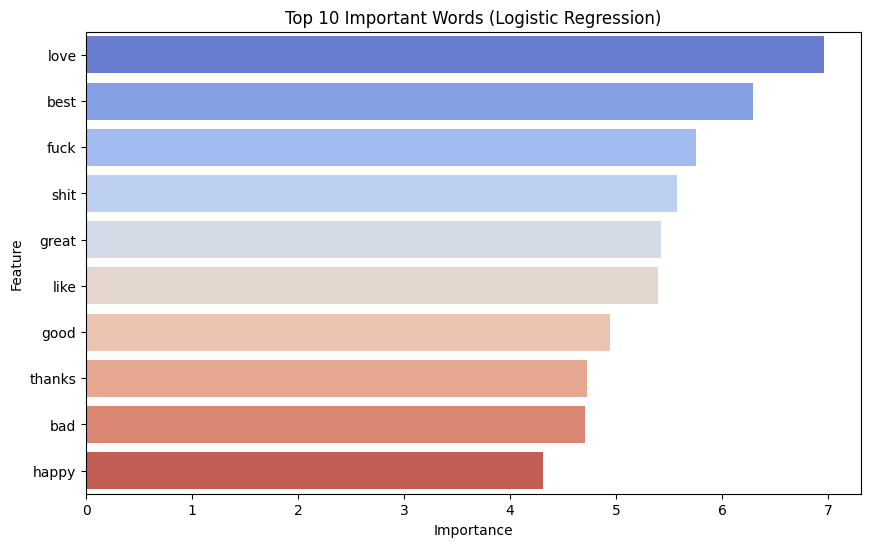

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=500, solver='liblinear')
lr.fit(X_train_balanced, y_train_balanced)

importance = np.abs(lr.coef_).mean(axis=0)
feature_names = np.array(vectorizer.get_feature_names_out())

feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

print("\n🔹 Top 10 Important Words for Sentiment Prediction:")
print(feature_importance.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feature_importance.head(10), palette="coolwarm")
plt.title("Top 10 Important Words (Logistic Regression)")
plt.show()

# Logistic Regression

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'penalty': 'l2', 'C': 10}

✅ Optimized Logistic Regression Performance:
Accuracy: 0.8145533532446375

Classification Report:
               precision    recall  f1-score   support

    Negative       0.74      0.72      0.73       853
     Neutral       0.76      0.84      0.80      1092
    Positive       0.90      0.84      0.87      1738

    accuracy                           0.81      3683
   macro avg       0.80      0.80      0.80      3683
weighted avg       0.82      0.81      0.82      3683



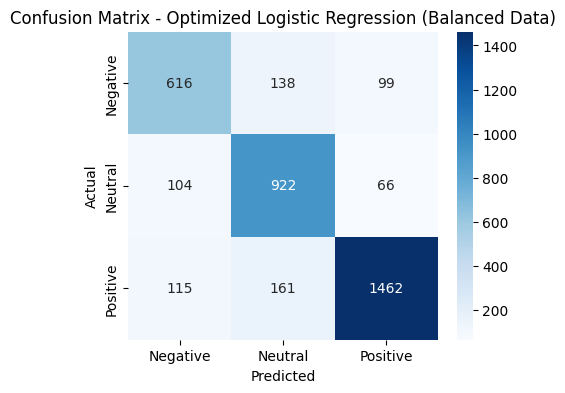

Logistic Regression model loaded!


In [44]:
# ⚡ Optimized Hyperparameter Tuning - Logistic Regression
# Parameter distribution (smaller + faster)
param_dist = {'C': [0.1, 1, 10], 'penalty': ['l2']}

# Randomized search (3-fold CV, only 3 combinations)
search = RandomizedSearchCV(
    LogisticRegression(solver='saga', max_iter=300, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=3, cv=3, random_state=42, verbose=1
)

search.fit(X_train_balanced, y_train_balanced)
print("Best Parameters:", search.best_params_)

# Best model
model = search.best_estimator_

# Predict on test data
y_pred = model.predict(X_test_tfidf)

# Evaluate
print("\n✅ Optimized Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Negative','Neutral','Positive']))

# Confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative','Neutral','Positive'],
            yticklabels=['Negative','Neutral','Positive'])
plt.title('Confusion Matrix - Optimized Logistic Regression (Balanced Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
import joblib

logreg_model = joblib.load("optimized_logistic_regression.pkl")
print("Logistic Regression model loaded!")

In [22]:
# 💬 Step: Predict Sentiment on Random Cleaned Tweets (Using Balanced Logistic Regression Model)
import random

# Map numeric labels back to readable sentiments
label_map_reverse = {0: "Negative", 1: "Neutral", 2: "Positive"}

# Randomly select 5–10 cleaned tweets
sample_df = df.sample(n=random.randint(5, 10), random_state=42)[['text', 'clean_text', 'sentiment']].reset_index(drop=True)

# Transform cleaned text using the trained TF-IDF vectorizer
X_sample_tfidf = vectorizer.transform(sample_df['clean_text'])

# Predict using the optimized balanced model
predicted_labels = model.predict(X_sample_tfidf)
predicted_proba = model.predict_proba(X_sample_tfidf)

# Add predictions to DataFrame
sample_df['Predicted_Sentiment'] = [label_map_reverse[label] for label in predicted_labels]
sample_df['Confidence'] = predicted_proba.max(axis=1).round(3)

# Compare actual vs predicted (if available)
if 'sentiment' in sample_df.columns:
    sample_df['Correct'] = np.where(sample_df['sentiment'].str.capitalize() == sample_df['Predicted_Sentiment'], "✅ Correct", "❌ Misclassified")

# Display predictions clearly
print("📢 Predictions on Random Tweets from Dataset (Using Cleaned Text):\n")
for i, row in sample_df.iterrows():
    print(f"📝 Tweet: {row['text']}")
    print(f"✅ Actual Sentiment: {row['sentiment'].capitalize()}")
    print(f"🔹 Predicted Sentiment: {row['Predicted_Sentiment']} ({row['Confidence']*100:.1f}% confidence)")
    print(f"{row['Correct']}\n" + "-"*70)

# Optional: display as DataFrame
display(sample_df[['text', 'clean_text', 'sentiment', 'Predicted_Sentiment', 'Confidence', 'Correct']])

📢 Predictions on Random Tweets from Dataset (Using Cleaned Text):

📝 Tweet: And the UHNW Wealth Manager award goes to...Jamie Black @sarasinpartners !  Congratulations #spearsawards
✅ Actual Sentiment: Positive
🔹 Predicted Sentiment: Positive (97.8% confidence)
✅ Correct
----------------------------------------------------------------------
📝 Tweet: @jdonofficial @thisisheart can you play a-ha on 1 nov for mine and magne f's birthdays pretty please jason? Ta, kati x
✅ Actual Sentiment: Positive
🔹 Predicted Sentiment: Positive (100.0% confidence)
✅ Correct
----------------------------------------------------------------------
📝 Tweet: @jeremycorbyn @lfi zionists deny stealing land/water/housing and bully those who say they r https://t.co/FebuzJYRAa https://t.co/ZKAL0qd0ts
✅ Actual Sentiment: Negative
🔹 Predicted Sentiment: Negative (76.3% confidence)
✅ Correct
----------------------------------------------------------------------
📝 Tweet: These comments from men in the CNN article I jus

,text,clean_text,sentiment,Predicted_Sentiment,Confidence,Correct
0,And the UHNW Wealth Manager award goes to...Ja...,uhnw wealth manager award goes jamie black sar...,positive,Positive,0.978,✅ Correct
1,@jdonofficial @thisisheart can you play a-ha o...,jdonofficial thisisheart play ha nov mine magn...,positive,Positive,1.000,✅ Correct
2,@jeremycorbyn @lfi zionists deny stealing land...,jeremycorbyn lfi zionists deny stealing land w...,negative,Negative,0.763,✅ Correct
3,These comments from men in the CNN article I j...,comments men cnn article tweeted women tech ab...,negative,Negative,0.686,✅ Correct
4,Just imagine. What advice d sisters gave to pr...,imagine advice sisters gave prince suyyash aam...,neutral,Neutral,0.830,✅ Correct
5,@MichelleDBeadle @TheHerd @ColinCowherd The be...,michelledbeadle theherd colincowherd best male...,positive,Positive,0.780,✅ Correct
6,ÛÏWe put an invisible veil between you and th...,put invisible veil believe hereafter,neutral,Neutral,0.972,✅ Correct
7,The Bulls should indeed more watchable this ye...,bulls indeed watchable year perhaps better bul...,positive,Positive,0.806,✅ Correct
8,@BigRallied honestly the only 2s team I had tr...,bigrallied honestly team trouble u baldy every...,positive,Positive,0.528,✅ Correct


In [23]:
# Step: Predict Sentiment on Custom Texts (Using Optimized Logistic Regression)
# Function to predict sentiment

def predict_sentiment_lr(text):
    cleaned_text = clean_text(text)
    transformed_text = vectorizer.transform([cleaned_text])  # Convert to TF-IDF
    prediction = model.predict(transformed_text)[0]
    prediction_proba = model.predict_proba(transformed_text)[0]

    label_map_reverse = {0: "Negative", 1: "Neutral", 2: "Positive"}
    sentiment = label_map_reverse.get(prediction, "Unknown")
    confidence = np.max(prediction_proba)

    return sentiment, confidence

# ✅ Test sample texts
test_texts = [
    "I love this product! It's amazing and works really well!",
    "This is the worst experience I've had. Totally disappointed.",
    "I feel so neutral about the whole situation, not too bad or good.",
    "Terrible customer service, they don’t even reply to emails.",
    "I don't know how to feel about this, it's a bit confusing.",
    "This product exceeded my expectations! Highly recommend.",
    "The weather is fine, nothing special today.",
    "I'm feeling really down today. Nothing is going right.",
    "The weather is fantastic today, I feel so happy and energetic!",
    "Not worth the money, total waste of time!"
]

# ✅ Predict and display results
print("\n📢 Predictions on Given Test Texts (Optimized Logistic Regression Model):")
print("-" * 80)
for text in test_texts:
    sentiment, confidence = predict_sentiment_lr(text)
    print(f"📝 Text: {text}")
    print(f"🔹 Predicted Sentiment: {sentiment} ({confidence*100:.1f}% confidence)")
    print("-" * 80)


📢 Predictions on Given Test Texts (Optimized Logistic Regression Model):
--------------------------------------------------------------------------------
📝 Text: I love this product! It's amazing and works really well!
🔹 Predicted Sentiment: Positive (100.0% confidence)
--------------------------------------------------------------------------------
📝 Text: This is the worst experience I've had. Totally disappointed.
🔹 Predicted Sentiment: Negative (99.9% confidence)
--------------------------------------------------------------------------------
📝 Text: I feel so neutral about the whole situation, not too bad or good.
🔹 Predicted Sentiment: Negative (51.2% confidence)
--------------------------------------------------------------------------------
📝 Text: Terrible customer service, they don’t even reply to emails.
🔹 Predicted Sentiment: Negative (84.1% confidence)
--------------------------------------------------------------------------------
📝 Text: I don't know how to feel about t

In [24]:
# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Extract coefficients from the trained model
coefficients = model.coef_[0]

# Top 10 words pushing sentiment positive
top_positive = feature_importance.sort_values(by='Importance', ascending=False).head(10)

# Top 10 words pushing sentiment negative
top_negative = feature_importance.sort_values(by='Importance', ascending=True).head(10)

print("🔹 Top 10 Positive Words:")
print(top_positive)

print("\n🔹 Top 10 Negative Words:")
print(top_negative)

🔹 Top 10 Positive Words:
     Feature  Importance
2649    love    6.965042
395     best    6.291336
1711    fuck    5.752268
3941    shit    5.573505
1896   great    5.428419
2547    like    5.397937
1858    good    4.940556
4406  thanks    4.727867
307      bad    4.708415
1977   happy    4.313155

🔹 Top 10 Negative Words:
              Feature  Importance
4860             wide    0.010517
785             claim    0.019297
1107           degree    0.020231
2713       management    0.020874
3476           proper    0.022429
3712        right way    0.026916
4716           videos    0.031551
42              added    0.031732
4389             text    0.031903
4599  tweeps followed    0.034914


🔹 Top 10 Positive Words (Strongly Increase Positive Sentiment):
     Feature  Importance
1711    fuck   10.073029
3941    shit    9.532368
2029    hell    9.076641
1072    dead    8.990236
2933  murder    8.827056
1081   death    8.300080
1494    fake    8.296044
307      bad    8.115740
243      ass    8.068804
626   cancer    7.919137

🔹 Top 10 Negative Words (Strongly Increase Negative Sentiment):
       Feature  Importance
395       best   -7.792525
3703      rich   -6.711972
4280     super   -6.354174
2649      love   -5.181525
1730  funniest   -4.909507
939       copy   -4.805808
458   blessing   -4.781508
287    awesome   -4.735461
1244     dream   -4.678098
3248   perfect   -4.392244


C:\Users\JIYA SONI\AppData\Local\Temp\ipykernel_20920\3087956930.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_positive, palette='Greens_r')


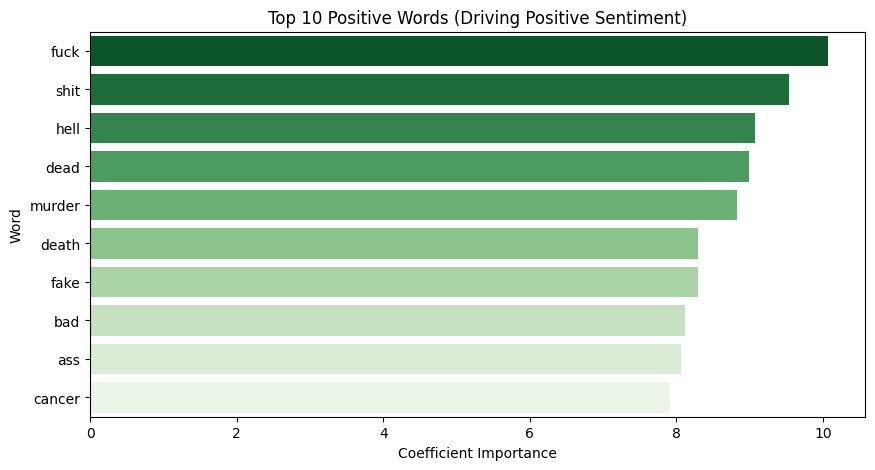

C:\Users\JIYA SONI\AppData\Local\Temp\ipykernel_20920\3087956930.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_negative, palette='Reds')


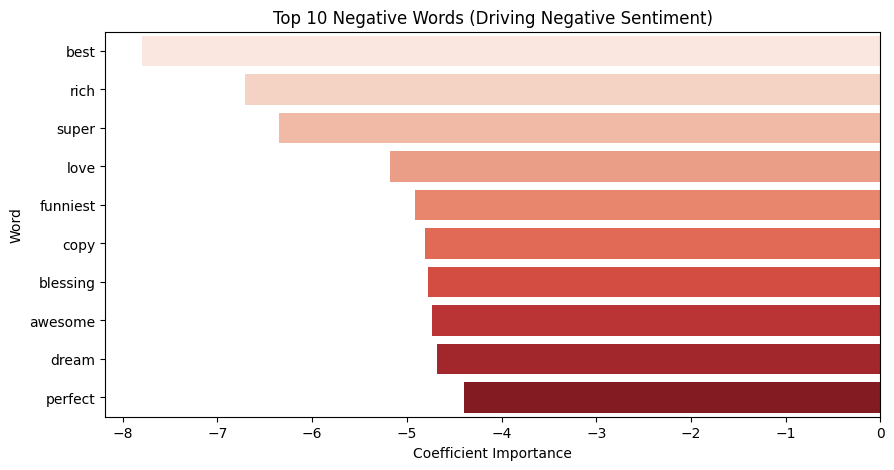

In [25]:
# 🌟 Step: Extract Top Positive & Negative Words (Logistic Regression)

# Get feature names from the trained TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Extract coefficients from the trained logistic regression model
coefficients = model.coef_[0]

# Create a DataFrame of word importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
})

# Sort for positive and negative influences
top_positive = feature_importance.sort_values(by='Importance', ascending=False).head(10)
top_negative = feature_importance.sort_values(by='Importance', ascending=True).head(10)

# Display results
print("🔹 Top 10 Positive Words (Strongly Increase Positive Sentiment):")
print(top_positive)

print("\n🔹 Top 10 Negative Words (Strongly Increase Negative Sentiment):")
print(top_negative)

# Visualization 

plt.figure(figsize=(10,5))
sns.barplot(x='Importance', y='Feature', data=top_positive, palette='Greens_r')
plt.title('Top 10 Positive Words (Driving Positive Sentiment)')
plt.xlabel('Coefficient Importance')
plt.ylabel('Word')
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x='Importance', y='Feature', data=top_negative, palette='Reds')
plt.title('Top 10 Negative Words (Driving Negative Sentiment)')
plt.xlabel('Coefficient Importance')
plt.ylabel('Word')
plt.show()


# SVM model

✅ Linear SVM Model Performance (Balanced Data):
Accuracy: 0.8199837089329352

Classification Report:
               precision    recall  f1-score   support

    Negative       0.75      0.73      0.74       853
     Neutral       0.76      0.85      0.80      1092
    Positive       0.90      0.85      0.87      1738

    accuracy                           0.82      3683
   macro avg       0.80      0.81      0.80      3683
weighted avg       0.82      0.82      0.82      3683



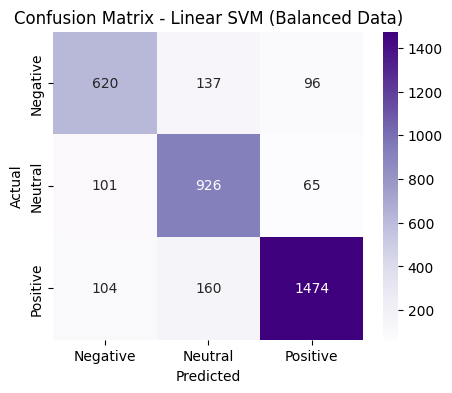

In [26]:
# Fast SVM for Text (Balanced TF-IDF Data)
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train faster SVM
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train_balanced, y_train_balanced)

# Predict
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluate
print("✅ Linear SVM Model Performance (Balanced Data):")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm, target_names=['Negative','Neutral','Positive']))

# Confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Purples',
            xticklabels=['Negative','Neutral','Positive'],
            yticklabels=['Negative','Neutral','Positive'])
plt.title('Confusion Matrix - Linear SVM (Balanced Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [27]:
df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone',
       'clean_text', 'sentiment', 'label'],
      dtype='object')

In [28]:
# Step: Predict Sentiment on Custom Texts using SVM Model (Balanced)
# Prediction function for SVM model

def predict_sentiment_svm(text):
    cleaned_text = clean_text(text)
    transformed_text = vectorizer.transform([cleaned_text])
    prediction = svm_model.predict(transformed_text)[0]
    score = svm_model.decision_function(transformed_text)
    confidence = np.max(score) / np.sum(np.abs(score))
    
    label_map_reverse = {0: "Negative", 1: "Neutral", 2: "Positive"}
    sentiment = label_map_reverse.get(prediction, "Unknown")
    
    return sentiment, confidence

# ✅ Sample texts to test
test_texts = [
    "I love this product! It's amazing and works really well!",
    "This is the worst experience I've had. Totally disappointed.",
    "I feel so neutral about the whole situation, not too bad or good.",
    "Terrible customer service, they don’t even reply to emails.",
    "I don't know how to feel about this, it's a bit confusing.",
    "This product exceeded my expectations! Highly recommend.",
    "The weather is fine, nothing special today.",
    "I'm feeling really down today. Nothing is going right.",
    "The weather is fantastic today, I feel so happy and energetic!",
    "Not worth the money, I regret buying this."
]

# ✅ Predict and display
print("\n📢 Predictions on Given Test Texts (SVM Model):")
print("-" * 80)
for text in test_texts:
    sentiment, confidence = predict_sentiment_svm(text)
    print(f"📝 Text: {text}")
    print(f"🔹 Predicted Sentiment: {sentiment} ({confidence*100:.1f}% confidence)")
    print("-" * 80)



📢 Predictions on Given Test Texts (SVM Model):
--------------------------------------------------------------------------------
📝 Text: I love this product! It's amazing and works really well!
🔹 Predicted Sentiment: Positive (37.7% confidence)
--------------------------------------------------------------------------------
📝 Text: This is the worst experience I've had. Totally disappointed.
🔹 Predicted Sentiment: Negative (35.2% confidence)
--------------------------------------------------------------------------------
📝 Text: I feel so neutral about the whole situation, not too bad or good.
🔹 Predicted Sentiment: Negative (-3.5% confidence)
--------------------------------------------------------------------------------
📝 Text: Terrible customer service, they don’t even reply to emails.
🔹 Predicted Sentiment: Negative (24.0% confidence)
--------------------------------------------------------------------------------
📝 Text: I don't know how to feel about this, it's a bit confusing.


In [29]:
import pickle

# Save correctly
with open('balanced_data.pkl', 'wb') as f:
    pickle.dump(df, f)

# Load again to test
with open('balanced_data.pkl', 'rb') as f:
    df_balanced = pickle.load(f)

print("✅ Successfully loaded balanced_data.pkl")

✅ Successfully loaded balanced_data.pkl


# Random Forest

✅ Random Forest model trained successfully!
💾 Model and vectorizer saved!

📈 Model Evaluation Results:
Accuracy: 0.844963345099104

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.66      0.73       853
           1       0.79      0.94      0.86      1092
           2       0.90      0.88      0.89      1738

    accuracy                           0.84      3683
   macro avg       0.83      0.83      0.83      3683
weighted avg       0.85      0.84      0.84      3683



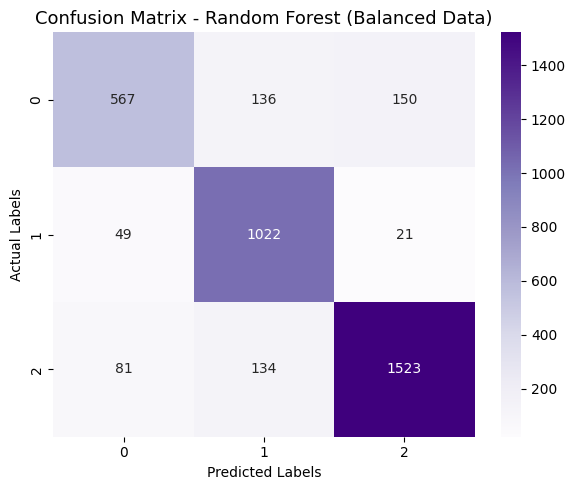


🔍 Sample Text Predictions:
🗣️ 'I love this product, it’s amazing!' → Predicted Sentiment: 2
🗣️ 'This service is terrible, I’m very disappointed.' → Predicted Sentiment: 1
🗣️ 'It was okay, nothing special.' → Predicted Sentiment: 2
🗨️ 'I love this product, it’s amazing!' → Sentiment: 2 | Confidence: 0.99
🗨️ 'This service is terrible, I’m very disappointed.' → Sentiment: 1 | Confidence: 0.46
🗨️ 'It was okay, nothing special.' → Sentiment: 2 | Confidence: 0.92


In [30]:
# 📦 Import Libraries
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# ✅ Step 1: Train Random Forest on Balanced Data

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_balanced, y_train_balanced)
print("✅ Random Forest model trained successfully!")

# 💾 Step 2: Save Model and Vectorizer
joblib.dump(rf, "rf_sentiment_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
print("💾 Model and vectorizer saved!")

# 🧩 Step 3: Predict on Test Set
y_pred = rf.predict(X_test_tfidf)

# 📊 Step 4: Evaluate Model
print("\n📈 Model Evaluation Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 5: Confusion Matrix Visualization 
unique_labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=unique_labels,
            yticklabels=unique_labels)
plt.title("Confusion Matrix - Random Forest (Balanced Data)", fontsize=13)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.tight_layout()
plt.show()

# Step 7: Predict on New Sample Texts

sample_texts = [
    "I love this product, it’s amazing!",
    "This service is terrible, I’m very disappointed.",
    "It was okay, nothing special."
]

# Transform using same TF-IDF vectorizer
sample_tfidf = vectorizer.transform(sample_texts)
sample_preds = rf.predict(sample_tfidf)

print("\n🔍 Sample Text Predictions:")
for text, pred in zip(sample_texts, sample_preds):
    print(f"🗣️ '{text}' → Predicted Sentiment: {pred}")

# 🔢 Step 8 (Optional): Show Confidence Scores

sample_probs = rf.predict_proba(sample_tfidf)
for text, pred, prob in zip(sample_texts, sample_preds, sample_probs):
    print(f"🗨️ '{text}' → Sentiment: {pred} | Confidence: {max(prob):.2f}")


In [31]:
# 💬 Predict Sentiment on Custom Test Sentences (Random Forest)

test_texts = [
    "The app keeps crashing, I’m frustrated.",
    "Wow! This feature is absolutely amazing!",
    "The service was okay, nothing special.",
    "Totally disappointed with the purchase.",
    "Everything works fine and I’m satisfied.",
]

# Optional: Map numeric or encoded labels to readable text
label_map_reverse = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

# Transform text using trained vectorizer
X_test_custom = vectorizer.transform(test_texts)

# Predict sentiment and confidence using Random Forest
preds_custom = rf.predict(X_test_custom)
pred_probs = rf.predict_proba(X_test_custom)

# Display predictions
print("\n📢 Predictions on Custom Test Sentences (Random Forest Model):\n")
for text, pred, prob in zip(test_texts, preds_custom, pred_probs):
    # sentiment = label_map_reverse[pred] if pred in label_map_reverse else pred
    confidence = round(prob.max() * 100, 1)
    print(f"📝 {text}")
    print(f"🔹 Predicted Sentiment: {sentiment} ({confidence}% confidence)")
    print("-" * 70)


📢 Predictions on Custom Test Sentences (Random Forest Model):

📝 The app keeps crashing, I’m frustrated.
🔹 Predicted Sentiment: Negative (59.7% confidence)
----------------------------------------------------------------------
📝 Wow! This feature is absolutely amazing!
🔹 Predicted Sentiment: Negative (100.0% confidence)
----------------------------------------------------------------------
📝 The service was okay, nothing special.
🔹 Predicted Sentiment: Negative (92.0% confidence)
----------------------------------------------------------------------
📝 Totally disappointed with the purchase.
🔹 Predicted Sentiment: Negative (50.0% confidence)
----------------------------------------------------------------------
📝 Everything works fine and I’m satisfied.
🔹 Predicted Sentiment: Negative (56.0% confidence)
----------------------------------------------------------------------


✅ Linear SVM and Random Forest models trained successfully!

✅ Model Accuracy (Trained on Balanced Data):
Linear SVM Accuracy: 0.8200
Random Forest Accuracy: 0.8450
Optimized Logistic Regression Accuracy: 0.8146

🔹 Linear SVM Classification Report:
               precision    recall  f1-score   support

    Negative       0.75      0.73      0.74       853
     Neutral       0.76      0.85      0.80      1092
    Positive       0.90      0.85      0.87      1738

    accuracy                           0.82      3683
   macro avg       0.80      0.81      0.80      3683
weighted avg       0.82      0.82      0.82      3683


🔹 Random Forest Classification Report:
               precision    recall  f1-score   support

    Negative       0.81      0.66      0.73       853
     Neutral       0.79      0.94      0.86      1092
    Positive       0.90      0.88      0.89      1738

    accuracy                           0.84      3683
   macro avg       0.83      0.83      0.83      3683
we

C:\Users\JIYA SONI\AppData\Local\Temp\ipykernel_20920\3715697219.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette=["#4B77BE", "#5FB404", "#FA5858"])
C:\Users\JIYA SONI\AppData\Local\Temp\ipykernel_20920\3715697219.py:67: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\JIYA SONI\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


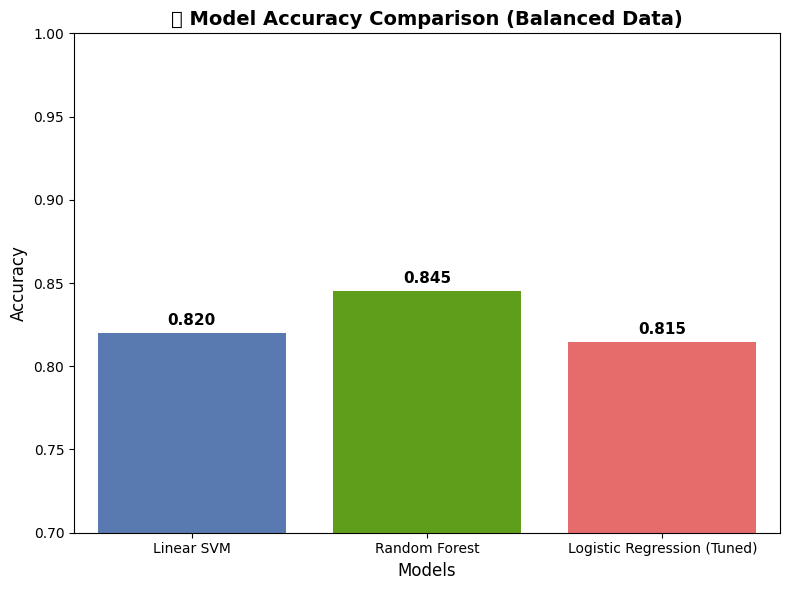

['random_forest_model.pkl']

In [32]:
# 📦 Import Libraries
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 1️⃣ Load or Define Models
# Load your pre-tuned logistic regression model
logreg_tuned = joblib.load("optimized_logreg.pkl")  # already tuned earlier

# Train only SVM and Random Forest
svm_model = LinearSVC(random_state=42)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)

svm_model.fit(X_train_balanced, y_train_balanced)
rf_model.fit(X_train_balanced, y_train_balanced)

print("✅ Linear SVM and Random Forest models trained successfully!")

#  2️⃣ Predict on TEST data (original imbalanced)
y_pred_svm = svm_model.predict(X_test_tfidf)
y_pred_rf = rf_model.predict(X_test_tfidf)
y_pred_lr = logreg_tuned.predict(X_test_tfidf)


# 3️⃣ Compute Accuracy Scores


svm_acc = accuracy_score(y_test, y_pred_svm)
rf_acc = accuracy_score(y_test, y_pred_rf)
lr_acc = accuracy_score(y_test, y_pred_lr)

print("\n✅ Model Accuracy (Trained on Balanced Data):")
print(f"Linear SVM Accuracy: {svm_acc:.4f}")
print(f"Random Forest Accuracy: {rf_acc:.4f}")
print(f"Optimized Logistic Regression Accuracy: {lr_acc:.4f}")

# 4️⃣ Classification Reports

print("\n🔹 Linear SVM Classification Report:\n", 
      classification_report(y_test, y_pred_svm, target_names=['Negative','Neutral','Positive']))

print("\n🔹 Random Forest Classification Report:\n", 
      classification_report(y_test, y_pred_rf, target_names=['Negative','Neutral','Positive']))

print("\n🔹 Optimized Logistic Regression Classification Report:\n", 
      classification_report(y_test, y_pred_lr, target_names=['Negative','Neutral','Positive']))

# 5️⃣ Plot Accuracy Comparison
models = ["Linear SVM", "Random Forest", "Logistic Regression (Tuned)"]
accuracies = [svm_acc, rf_acc, lr_acc]

plt.figure(figsize=(8,6))
sns.barplot(x=models, y=accuracies, palette=["#4B77BE", "#5FB404", "#FA5858"])

plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("📊 Model Accuracy Comparison (Balanced Data)", fontsize=14, fontweight='bold')
plt.ylim(0.7, 1.0)

# Annotate bar values
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.3f}", ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# 6️⃣ Save Trained Models
joblib.dump(svm_model, "linear_svm_model.pkl")
joblib.dump(rf_model, "random_forest_model.pkl")

# print("\n SVM and Random Forest models saved successfully!")


# Bert Model

In [33]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load pre-trained tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
from sklearn.model_selection import train_test_split

# Correct way to split and reset index
X = df['clean_text'].reset_index(drop=True)
y = df['label'].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to lists or NumPy arrays for BERT
X_train = list(X_train)
X_test = list(X_test)
y_train = y_train.values
y_test = y_test.values


In [35]:
# Tokenize text data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# Convert to torch Dataset
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, y_train)
test_dataset = TweetDataset(test_encodings, y_test)


✅ BERT Model Evaluation on Test Data:
Accuracy: 0.8944

Classification Report:
               precision    recall  f1-score   support

    Negative       0.86      0.88      0.87       853
     Neutral       0.87      0.90      0.89      1092
    Positive       0.93      0.89      0.91      1738

    accuracy                           0.89      3683
   macro avg       0.89      0.89      0.89      3683
weighted avg       0.90      0.89      0.89      3683



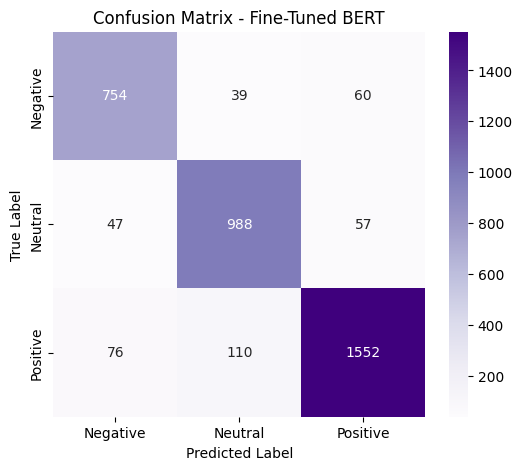


📢 Sample Predictions from BERT Model:

                                                Text Actual Sentiment  \
0      gon na dress referee scare mourinho halloween         Negative   
1  love paul les heart heart one quiet strong mom...         Positive   
2  happy birthday cutest twins around b dizzz jordan         Positive   
3  lonely tiger live interview clips echoplex rad...         Negative   
4                                       take gallows          Neutral   
5                   captainsparklez ho logie trick u         Negative   
6  elephone p mah battery review specifications r...          Neutral   
7  teampapii one state struggle make ends meet il...         Negative   
8                                      keypad qz key          Neutral   
9                                                             Neutral   

  Predicted Sentiment  Confidence  
0            Negative       0.957  
1            Positive       0.990  
2            Positive       0.991  
3           

In [37]:
# Path to your uploaded model files
model_path = r"C:\Users\JIYA SONI\Downloads\tweet\bert_sentiment_model"

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Predict Function (Batch Mode)
def bert_predict(texts):
    all_preds, all_probs = [], []
    batch_size = 16  # Adjust based on your hardware
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        encodings = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=128
        ).to(device)

        with torch.no_grad():
            outputs = model(**encodings)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    # Convert to readable labels
    readable_preds = [label_map[p] for p in all_preds]
    return np.array(all_preds), readable_preds, np.array(all_probs)


# Evaluate on Your Test Data
y_pred_ids, y_pred_named, y_probs = bert_predict(list(X_test))
label_map_reverse = {0: "Negative", 1: "Neutral", 2: "Positive"}
y_test_named = [label_map_reverse[y] for y in y_test]

# Accuracy and classification report
acc = accuracy_score(y_test, y_pred_ids)
print("✅ BERT Model Evaluation on Test Data:")
print(f"Accuracy: {acc:.4f}\n")
print("Classification Report:\n", classification_report(y_test_named, y_pred_named))

# Confusion Matrix
cm = confusion_matrix(y_test_named, y_pred_named, labels=['Negative', 'Neutral', 'Positive'])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Negative','Neutral','Positive'],
            yticklabels=['Negative','Neutral','Positive'])
plt.title("Confusion Matrix - Fine-Tuned BERT")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#  Show Random Predictions
sample_df = pd.DataFrame({
    "Text": X_test[:10],
    "Actual Sentiment": y_test_named[:10],
    "Predicted Sentiment": y_pred_named[:10],
    "Confidence": [round(np.max(p), 3) for p in y_probs[:10]]
})

print("\n📢 Sample Predictions from BERT Model:\n")
print(sample_df)


In [38]:
# Predict Sentiment on Custom Texts (Using Loaded BERT)
def bert_predict_custom(texts):
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    all_preds, all_probs = [], []

    for text in texts:
        encodings = tokenizer(
            [text],
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=128
        ).to(device)

        with torch.no_grad():
            outputs = model(**encodings)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            pred = torch.argmax(probs, dim=1).item()

        all_preds.append(pred)
        all_probs.append(probs.cpu().numpy()[0])

    for text, pred, prob in zip(texts, all_preds, all_probs):
        label = label_map[pred]
        confidence = round(float(np.max(prob)) * 100, 2)
        print(f"📝 Text: {text}")
        print(f"🔹 Predicted Sentiment: {label} ({confidence}% confidence)")
        print("-" * 70)

# 🧠 Test on Random Sentences
sample_texts = [
    "I love how this app works, it’s so smooth!",
    "This is the worst update ever, I hate it.",
    "It’s okay, nothing too great or bad.",
    "Amazing performance and excellent service!",
    "The movie was decent, but nothing special."
    "The service was acceptable.",
    "I’m not satisfied with the response time."
]

bert_predict_custom(sample_texts)


📝 Text: I love how this app works, it’s so smooth!
🔹 Predicted Sentiment: Positive (99.01% confidence)
----------------------------------------------------------------------
📝 Text: This is the worst update ever, I hate it.
🔹 Predicted Sentiment: Negative (96.73% confidence)
----------------------------------------------------------------------
📝 Text: It’s okay, nothing too great or bad.
🔹 Predicted Sentiment: Positive (68.25% confidence)
----------------------------------------------------------------------
📝 Text: Amazing performance and excellent service!
🔹 Predicted Sentiment: Positive (99.06% confidence)
----------------------------------------------------------------------
📝 Text: The movie was decent, but nothing special.The service was acceptable.
🔹 Predicted Sentiment: Positive (96.47% confidence)
----------------------------------------------------------------------
📝 Text: I’m not satisfied with the response time.
🔹 Predicted Sentiment: Negative (91.34% confidence)
--------

In [ ]:
# Accuracy Comparison

✅ Model Accuracy Comparison:
BERT Accuracy: 0.8944
SVM Accuracy: 0.8200
Random Forest Accuracy: 0.8450
Logistic Regression Accuracy: 0.8146

📊 BERT Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.88      0.87       853
           2       0.87      0.90      0.89      1092
           3       0.93      0.89      0.91      1738

    accuracy                           0.89      3683
   macro avg       0.89      0.89      0.89      3683
weighted avg       0.90      0.89      0.89      3683



C:\Users\JIYA SONI\AppData\Local\Temp\ipykernel_20920\931394812.py:53: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\JIYA SONI\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


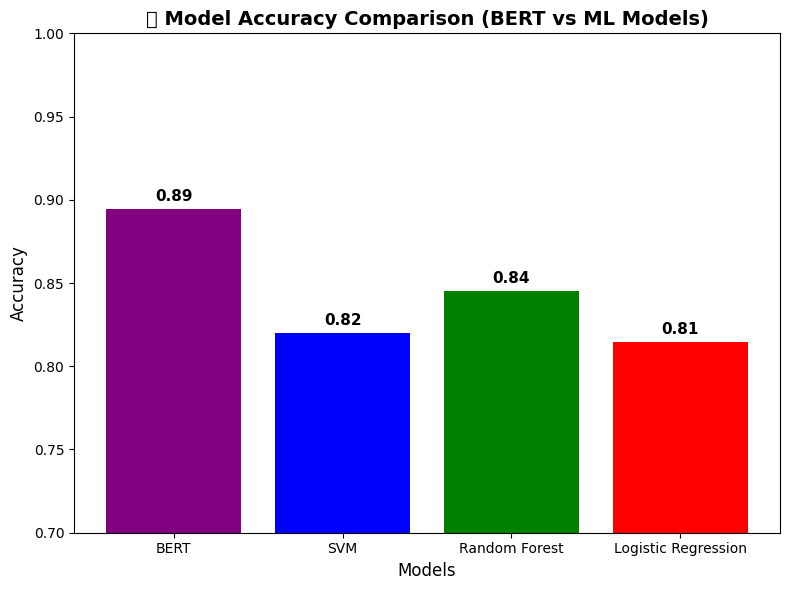

In [39]:
# Prepare True and Predicted Labels for BERT

true_labels = y_test_named
predicted_labels = y_pred_named

# Define label mapping
label_mapping = {
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3
}

# Convert true and predicted labels to numeric form
true_labels_numeric = [label_mapping[label] for label in true_labels]
predicted_labels_numeric = [label_mapping[label] for label in predicted_labels]

# 🧮 Compute Accuracies for Each Model
# BERT Accuracy
bert_accuracy = accuracy_score(true_labels_numeric, predicted_labels_numeric)

# SVM, Random Forest, and Logistic Regression (already computed earlier)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
lr_accuracy = accuracy_score(y_test, y_pred_lr)

# Print all accuracies
print("✅ Model Accuracy Comparison:")
print(f"BERT Accuracy: {bert_accuracy:.4f}")
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

# 🧾 Classification Report for BERT
print("\n📊 BERT Classification Report:\n",
      classification_report(true_labels_numeric, predicted_labels_numeric, zero_division=1))

# 📈 Plot Accuracy Comparison
models = ["BERT", "SVM", "Random Forest", "Logistic Regression"]
accuracies = [bert_accuracy, svm_accuracy, rf_accuracy, lr_accuracy]

plt.figure(figsize=(8,6))
plt.bar(models, accuracies, color=["purple", "blue", "green", "red"])

plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("📊 Model Accuracy Comparison (BERT vs ML Models)", fontsize=14, fontweight='bold')
plt.ylim(0.7, 1.0)

# Show accuracy values on top of bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.2f}", ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


In [49]:
# -------------------------------------------------------------
# ✅ LOAD ALL SAVED MODELS
# -------------------------------------------------------------
import joblib
import numpy as np
import torch

# Classical models
rf_model = joblib.load("random_forest_model.pkl")
svm_model = joblib.load("linear_svm_model.pkl")
logreg_model = joblib.load("optimized_logistic_regression.pkl")

# TF-IDF vectorizer
vectorizer = joblib.load("tfidf_vectorizer.pkl")

print("Classical Models & Vectorizer Loaded Successfully!")

# -------------------------------------------------------------
# ✅ LOAD BERT MODEL SAFELY (rename to bert_model)
# -------------------------------------------------------------
from transformers import AutoTokenizer, AutoModelForSequenceClassification

bert_path = r"C:\Users\JIYA SONI\Downloads\tweet\bert_sentiment_model"

tokenizer = AutoTokenizer.from_pretrained(bert_path)
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()

print("BERT Loaded Successfully!")


# -------------------------------------------------------------
# 🔮 FIXED BERT PREDICT FUNCTION
# -------------------------------------------------------------
def bert_predict(texts):
    all_ids = []
    all_preds = []
    all_probs = []

    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    batch_size = 16

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]

        encodings = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        ).to(device)

        with torch.no_grad():
            outputs = bert_model(**encodings)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            ids = torch.argmax(probs, dim=1)

        all_ids.extend(ids.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend([label_map[i] for i in ids.cpu().numpy()])

    return all_ids, all_preds, all_probs


# -------------------------------------------------------------
# 🔮 ONE-LINE PREDICTIONS ACROSS ALL 4 MODELS (FINAL VERSION)
# -------------------------------------------------------------
def print_one_line_predictions(sentences):
    tfidf_features = vectorizer.transform(sentences)

    # Classical model predictions
    rf_preds = rf_model.predict(tfidf_features)
    svm_preds = svm_model.predict(tfidf_features)
    logreg_preds = logreg_model.predict(tfidf_features)

    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

    rf_named = [label_map[p] for p in rf_preds]
    svm_named = [label_map[p] for p in svm_preds]
    logreg_named = [label_map[p] for p in logreg_preds]

    # BERT predictions
    bert_ids, bert_named, bert_probs = bert_predict(sentences)

    for i, text in enumerate(sentences):
        print(f"{i+1}. {text}")
        print(f"👉 RF: {rf_named[i]} | "
              f"SVM: {svm_named[i]} | "
              f"LR: {logreg_named[i]} | "
              f"BERT: {bert_named[i]} ({round(float(max(bert_probs[i])), 3)})\n")


# -------------------------------------------------------------
# 🔍 TEST SENTENCES (You can edit)
# -------------------------------------------------------------
test_sentences = [
    "I feel really sad and disappointed today.",
    "What a terrible mistake, I regret doing this.",
    "This makes me feel anxious and upset.",
    "The quality is below expectations.",
    "This was surprisingly enjoyable!",
    "Very disappointing and depressing.",
    "It made me angry and frustrated.",
    "I don’t like this product at all.",
    "Amazing performance, totally worth it!",
    "Absolutely wonderful service."
]

# -------------------------------------------------------------
# 🚀 RUN ONE-LINE PREDICTION
# -------------------------------------------------------------
print_one_line_predictions(test_sentences)


Classical Models & Vectorizer Loaded Successfully!
BERT Loaded Successfully!

✨ FINAL MODEL COMPARISON (One-Line Format)

1. I feel really sad and disappointed today.
👉 RF: Negative | SVM: Negative | LR: Negative | BERT: Negative (0.957)

2. What a terrible mistake, I regret doing this.
👉 RF: Negative | SVM: Negative | LR: Negative | BERT: Negative (0.96)

3. This makes me feel anxious and upset.
👉 RF: Negative | SVM: Negative | LR: Negative | BERT: Negative (0.961)

4. The quality is below expectations.
👉 RF: Neutral | SVM: Neutral | LR: Neutral | BERT: Neutral (0.854)

5. This was surprisingly enjoyable!
👉 RF: Neutral | SVM: Neutral | LR: Neutral | BERT: Positive (0.989)

6. Very disappointing and depressing.
👉 RF: Neutral | SVM: Neutral | LR: Neutral | BERT: Negative (0.971)

7. It made me angry and frustrated.
👉 RF: Neutral | SVM: Negative | LR: Negative | BERT: Negative (0.959)

8. I don’t like this product at all.
👉 RF: Positive | SVM: Positive | LR: Positive | BERT: Negative (0.

# NER model

In [50]:
from transformers import pipeline

# Load pre-trained Named Entity Recognition model
ner_pipeline = pipeline("ner", model="dslim/bert-base-NER", grouped_entities=True)


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
C:\Users\JIYA SONI\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\pipelines\token_classification.py:186: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(


In [51]:
def extract_entities(texts, max_display=3):
    """
    Extract named entities from a list of texts.
    Returns a list of dictionaries {text, entities}.
    """
    results = []
    for i, text in enumerate(texts):
        entities = ner_pipeline(text)
        entities_clean = [
            {"entity": e["entity_group"], "word": e["word"], "score": round(e["score"], 3)}
            for e in entities
        ]
        results.append({"text": text, "entities": entities_clean})
        if i < max_display:
            print(f"\n📝 Text: {text}")
            print("🔹 Entities Found:", entities_clean)
    return results


In [52]:
sample_texts = [
    "Prime Minister Narendra Modi met Joe Biden at the G20 Summit in Delhi.",
    "Apple is partnering with OpenAI to integrate ChatGPT into Siri.",
    "Cristiano Ronaldo scored for Al Nassr in Riyadh."
]

ner_results = extract_entities(sample_texts)





📝 Text: Prime Minister Narendra Modi met Joe Biden at the G20 Summit in Delhi.
🔹 Entities Found: [{'entity': 'PER', 'word': 'Narendra Modi', 'score': np.float32(0.906)}, {'entity': 'PER', 'word': 'Joe Biden', 'score': np.float32(0.925)}, {'entity': 'MISC', 'word': 'G20 Summit', 'score': np.float32(0.992)}, {'entity': 'LOC', 'word': 'Delhi', 'score': np.float32(0.999)}]

📝 Text: Apple is partnering with OpenAI to integrate ChatGPT into Siri.
🔹 Entities Found: [{'entity': 'ORG', 'word': 'Apple', 'score': np.float32(0.999)}, {'entity': 'ORG', 'word': 'OpenAI', 'score': np.float32(0.997)}, {'entity': 'MISC', 'word': 'Cha', 'score': np.float32(0.812)}, {'entity': 'MISC', 'word': '##GP', 'score': np.float32(0.93)}, {'entity': 'LOC', 'word': 'Sir', 'score': np.float32(0.359)}]

📝 Text: Cristiano Ronaldo scored for Al Nassr in Riyadh.
🔹 Entities Found: [{'entity': 'PER', 'word': 'C', 'score': np.float32(0.999)}, {'entity': 'PER', 'word': '##ristiano Ronaldo', 'score': np.float32(0.91)}, {'ent

In [53]:
# Apply NER to random 10 tweets from your dataset
sample_df = df.sample(10, random_state=42)[["clean_text", "sentiment"]].reset_index(drop=True)

def get_entities(text):
    entities = ner_pipeline(text)
    return [e['word'] for e in entities]

sample_df["entities"] = sample_df["clean_text"].apply(get_entities)

# Display results
print(sample_df[["clean_text", "sentiment", "entities"]])


                                          clean_text sentiment entities
0  uhnw wealth manager award goes jamie black sar...  positive       []
1  jdonofficial thisisheart play ha nov mine magn...  positive       []
2  jeremycorbyn lfi zionists deny stealing land w...  negative       []
3  comments men cnn article tweeted women tech ab...  negative       []
4  imagine advice sisters gave prince suyyash aam...   neutral     [su]
5  michelledbeadle theherd colincowherd best male...  positive       []
6               put invisible veil believe hereafter   neutral       []
7  bulls indeed watchable year perhaps better bul...  positive       []
8  bigrallied honestly team trouble u baldy every...  positive       []
9  danielwickham think mb isis could viewed light...   neutral       []


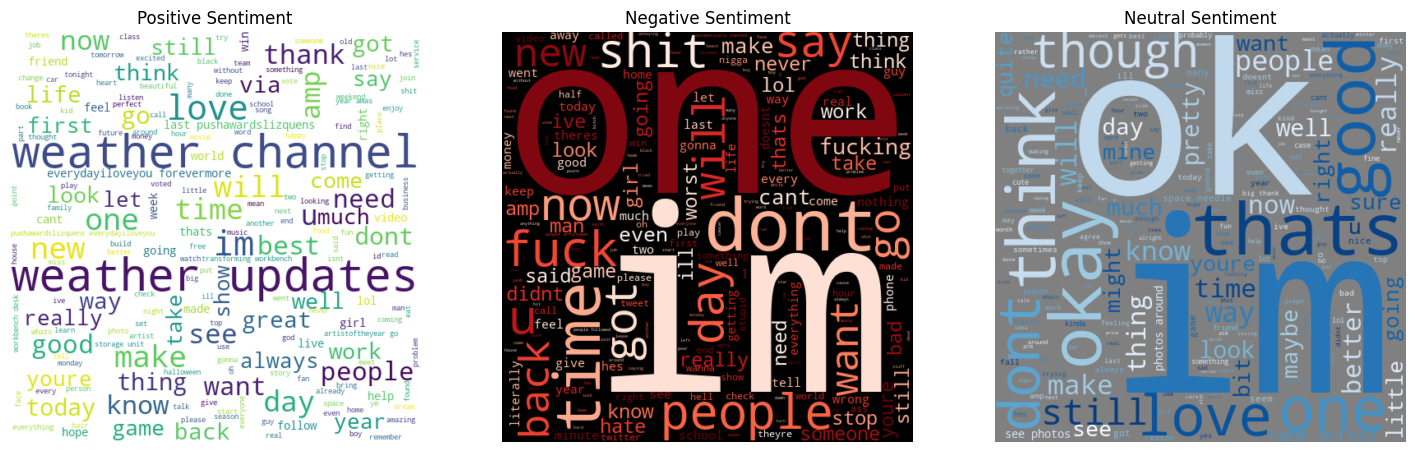

In [54]:
# Word Cloud 
# Load your dataset
df = pd.read_csv("tweet_data_with_sentiment.csv")  # Update with your actual file name

# Separate tweets by sentiment using cleaned_text and predicted_sentiment
positive_tweets = " ".join(df[df['predicted_sentiment'] == 'Positive']['cleaned_text'])
negative_tweets = " ".join(df[df['predicted_sentiment'] == 'Negative']['cleaned_text'])
neutral_tweets = " ".join(df[df['predicted_sentiment'] == 'Neutral']['cleaned_text'])

# Generate word clouds
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

wordcloud_pos = WordCloud(width=500, height=500, background_color="white").generate(positive_tweets)
axes[0].imshow(wordcloud_pos, interpolation="bilinear")
axes[0].set_title("Positive Sentiment")
axes[0].axis("off")

wordcloud_neg = WordCloud(width=500, height=500, background_color="black", colormap="Reds").generate(negative_tweets)
axes[1].imshow(wordcloud_neg, interpolation="bilinear")
axes[1].set_title("Negative Sentiment")
axes[1].axis("off")

wordcloud_neu = WordCloud(width=500, height=500, background_color="gray", colormap="Blues").generate(neutral_tweets)
axes[2].imshow(wordcloud_neu, interpolation="bilinear")
axes[2].set_title("Neutral Sentiment")
axes[2].axis("off")

plt.show()


In [55]:
#  FULL FINAL SENTIMENT PREDICTION PIPELINE
# Using Random Forest, SVM, Logistic Regression, and BERT
import joblib
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 📌 Load Classical ML Models
rf_model = joblib.load("random_forest_model.pkl")
svm_model = joblib.load("linear_svm_model.pkl")
logreg_model = joblib.load("optimized_logistic_regression.pkl")

vectorizer = joblib.load("tfidf_vectorizer.pkl")

print("ML Models & Vectorizer Loaded Successfully!\n")


# 📌 Load BERT Model

bert_path = r"C:\Users\JIYA SONI\Downloads\tweet\bert_sentiment_model"
tokenizer = AutoTokenizer.from_pretrained(bert_path)
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()

print("BERT Loaded Successfully!\n")

label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

# 📌 BERT Prediction Function

def bert_predict(texts):
    preds, probs = [], []

    for text in texts:
        encoding = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=128
        ).to(device)

        with torch.no_grad():
            output = bert_model(**encoding)
            prob = torch.softmax(output.logits, dim=1).cpu().numpy()[0]
            pred = np.argmax(prob)

        preds.append(label_map[pred])
        probs.append(prob.max())

    return preds, probs

# 📌 Test Sentences (25)
test_sentences = [
    "I absolutely love this! It made my day.",
    "This is the worst thing I've ever bought.",
    "I'm not sure how I feel about this.",
    "The experience was pleasant and smooth.",
    "I feel really sad and disappointed today.",
    "What a terrible mistake, I regret doing this.",
    "This is okay, nothing special at all.",
    "Such a joyful moment, I’m really happy!",
    "The quality is below expectations.",
    "Everything happened better than expected!",
    "This makes me feel anxious and upset.",
    "I think this could be improved a lot.",
    "Amazing performance, totally worth it!",
    "Not good, not bad, just average.",
    "I'm extremely unhappy with the results.",
    "This was surprisingly enjoyable!",
    "Worst service ever received.",
    "Pretty decent experience overall.",
    "I don’t like this product at all.",
    "This product exceeded all expectations!",
    "Feeling confused, not sure if I like it.",
    "Absolutely wonderful service.",
    "Very disappointing and depressing.",
    "Completely satisfied and happy!",
    "It made me angry and frustrated."
]


# ------------------------------------------------
# 📌 Classical ML Predictions
# ------------------------------------------------
X_tfidf = vectorizer.transform(test_sentences)

rf_preds = [label_map[p] for p in rf_model.predict(X_tfidf)]
svm_preds = [label_map[p] for p in svm_model.predict(X_tfidf)]
log_preds = [label_map[p] for p in logreg_model.predict(X_tfidf)]

# ------------------------------------------------
# 📌 BERT Predictions
# ------------------------------------------------
bert_preds, bert_conf = bert_predict(test_sentences)

# ------------------------------------------------
# 📌 Build Final Comparison Table
# ------------------------------------------------
comparison_df = pd.DataFrame({
    "Text": test_sentences,
    "Random Forest": rf_preds,
    "SVM": svm_preds,
    "Logistic Regression": log_preds,
    "BERT (Best)": bert_preds,
    "BERT Confidence": [round(c, 3) for c in bert_conf]
})

print("\n✨ Sentiment Comparison Across All Models:\n")
print(comparison_df)


ML Models & Vectorizer Loaded Successfully!

BERT Loaded Successfully!


✨ Sentiment Comparison Across All Models:

                                             Text Random Forest       SVM  \
0         I absolutely love this! It made my day.      Positive  Positive   
1       This is the worst thing I've ever bought.      Negative  Negative   
2             I'm not sure how I feel about this.      Positive  Positive   
3         The experience was pleasant and smooth.       Neutral  Positive   
4       I feel really sad and disappointed today.      Negative  Negative   
5   What a terrible mistake, I regret doing this.      Negative  Negative   
6           This is okay, nothing special at all.      Positive  Positive   
7         Such a joyful moment, I’m really happy!      Positive  Positive   
8              The quality is below expectations.       Neutral   Neutral   
9       Everything happened better than expected!      Positive  Positive   
10          This makes me feel anxiou